In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from training_utils import CIFAR10_dataloaders, training_monitor

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)  # Skip connection

In [3]:
class CNNResBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # Initial convolution layer (no skip connection here)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),  # Added
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Residual Block (instead of normal conv layers)
            ResidualBlock(32),

            # Another downsampling layer
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),  # Added
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Second Residual Block
            ResidualBlock(64),

            # Flatten
            nn.Flatten(),

            # Fully connected layers
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, 10)  
        )

    def forward(self, x):
        return self.model(x)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/30 [00:00<?, ?it/s]

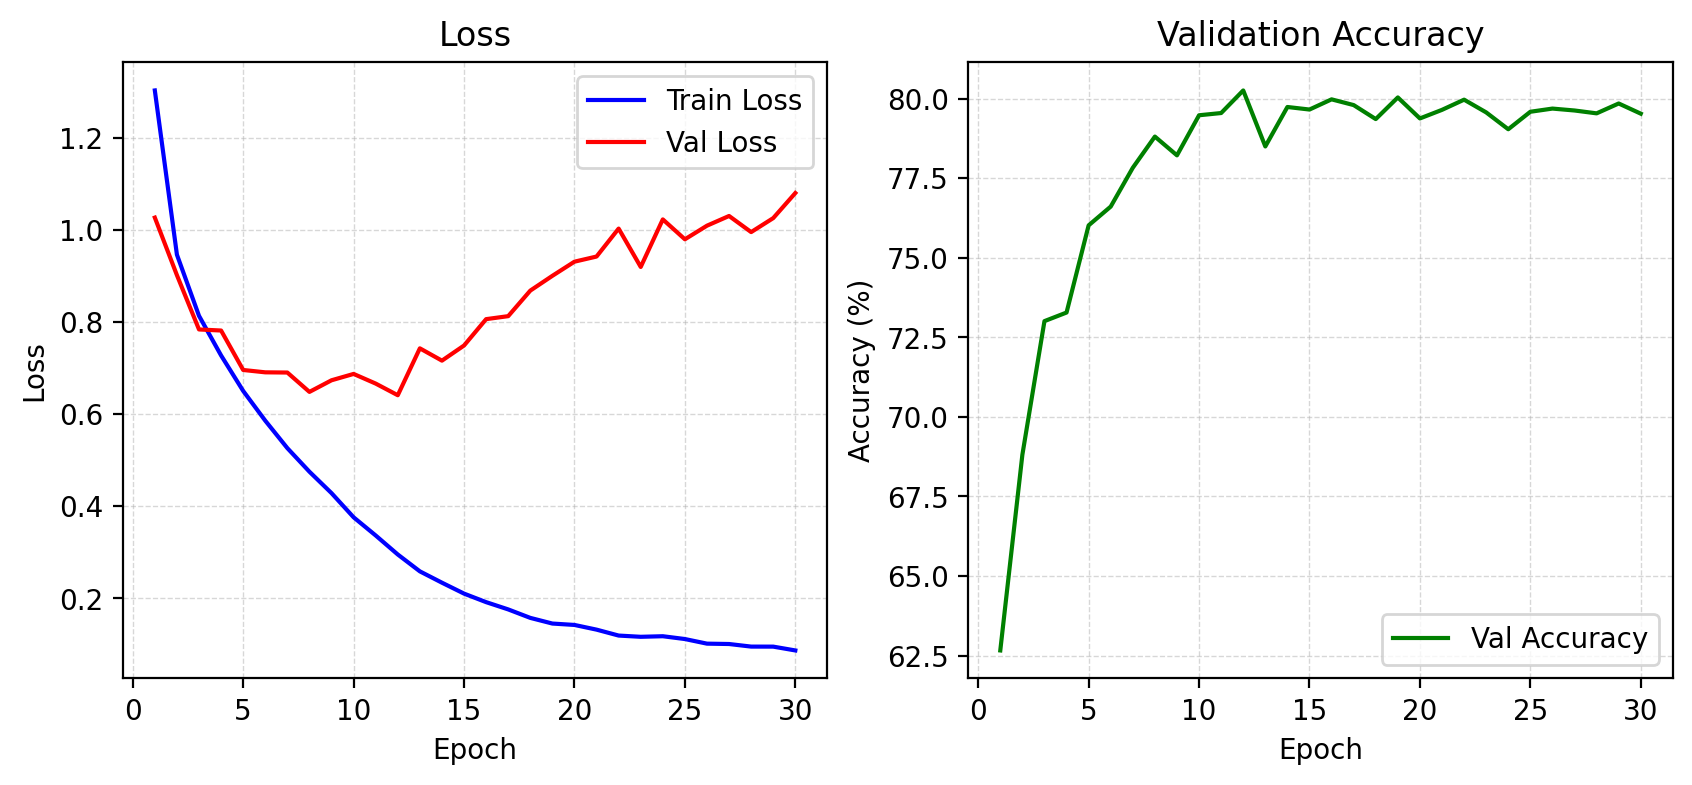

Epoch 30/30: 100%|##########| 30/30 [03:45<00:00,  7.57s/it]

|       Epoch        |     Train loss     |  Validation loss   | Validation accuracy, %  |
__________________________________________________________________________________________
|         1          |       1.3025       |       1.0265       |         62.6600         |
|         2          |       0.9461       |       0.9016       |         68.8100         |
|         3          |       0.8133       |       0.7837       |         73.0100         |
|         4          |       0.7273       |       0.7814       |         73.2800         |
|         5          |       0.6503       |       0.6958       |         76.0200         |
|         6          |       0.5858       |       0.6907       |         76.6100         |
|         7          |       0.5262       |       0.6902       |         77.8300         |
|         8          |       0.4750       |       0.6482       |         78.8100         |
|         9          |       0.4285       |       0.6734       |         78.2200         |

In [4]:
trainloader, testloader, classes = CIFAR10_dataloaders(batch_size=64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNResBlock().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30

trained_model = training_monitor(device, model, optimizer, criterion, num_epochs, trainloader, testloader)
